In [1]:
import numpy as np
import pandas as pd
import os
import math
from operator import truediv
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import warnings
warnings.filterwarnings('ignore')


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)


windowSize = 35
batch_size = 64

def padding(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createPatch(X, y, windowSize=windowSize):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padding(X, margin=margin)

    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0

    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1


    patchesData = patchesData[patchesLabels > 0, :, :, :]
    patchesLabels = patchesLabels[patchesLabels > 0]
    patchesLabels -= 1


    patchesData = patchesData.transpose((0, 3, 1, 2))

    return patchesData, patchesLabels


def applyPCA(X, numComponents=15):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX


def splitTrainTestSet(X, y, randomState=42):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.7, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test



In [8]:
import h5py

houston18_file = h5py.File('/content/drive/MyDrive/proje/Houston18.mat', 'r')
houston18_gt_file = h5py.File('/content/drive/MyDrive/proje/Houston18_7gt.mat', 'r')

X = np.array(houston18_file['ori_data'])
y = np.array(houston18_gt_file['map'])

X = np.transpose(X, (1, 2, 0))

X=applyPCA(X)

X,y=createPatch(X,y)

print(X.shape)
print(y.shape)
device = torch.device("cuda")


X_train,X_val,X_test,y_train,y_val,y_test=splitTrainTestSet(X,y)

(53200, 15, 35, 35)
(53200,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models


class HyperSpectralDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label



train_dataset = HyperSpectralDataset(
    data=torch.tensor(X_train, dtype=torch.float32),
    labels=torch.tensor(y_train, dtype=torch.long)
    )

val_dataset = HyperSpectralDataset(
    data=torch.tensor(X_val, dtype=torch.float32),
    labels=torch.tensor(y_val, dtype=torch.long)
    )


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=64,shuffle=True)

NameError: name 'X_train' is not defined

In [ ]:

####  Resnet #########

model = models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(15, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)

model.to(device)





Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 112MB/s]


ResNet(
  (conv1): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [ ]:
######### DenseNet  #########

model = models.densenet121(pretrained=True)
original_conv1 = model.features.conv0
model.features.conv0 = nn.Conv2d(15, original_conv1.out_channels, kernel_size=original_conv1.kernel_size,
                                 stride=original_conv1.stride, padding=original_conv1.padding, bias=False)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 7)


model.to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 49.8MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
####İnception####

model = models.googlenet(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
model.to(device)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 181MB/s]


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
########  Efficient ####

model = models.efficientnet_b0(pretrained=True)
model.features[0][0] = nn.Conv2d(15, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=7, bias=True)
)
model.to(device)



Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 148MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(15, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiva

In [ ]:

num_epochs = 20
learning_rate = 0.001
num_classes = 16

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
for epoch in range(20):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass ve optimizasyon
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    # Validation adımı
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%,Train Accuracy: {train_accuracy:.2f}')

print('Training Finished')

Epoch [1/20], Train Loss: 0.6158, Val Loss: 0.3125, Accuracy: 89.29%,Train Accuracy: 79.61
Epoch [2/20], Train Loss: 0.2645, Val Loss: 0.1854, Accuracy: 93.16%,Train Accuracy: 90.75
Epoch [3/20], Train Loss: 0.1726, Val Loss: 0.1437, Accuracy: 94.84%,Train Accuracy: 94.14
Epoch [4/20], Train Loss: 0.1262, Val Loss: 0.1193, Accuracy: 95.68%,Train Accuracy: 95.71
Epoch [5/20], Train Loss: 0.0978, Val Loss: 0.1541, Accuracy: 95.35%,Train Accuracy: 96.35
Epoch [6/20], Train Loss: 0.0879, Val Loss: 0.1325, Accuracy: 95.44%,Train Accuracy: 96.83
Epoch [7/20], Train Loss: 0.0722, Val Loss: 0.1081, Accuracy: 96.38%,Train Accuracy: 97.40
Epoch [8/20], Train Loss: 0.0701, Val Loss: 0.1683, Accuracy: 95.13%,Train Accuracy: 97.53
Epoch [9/20], Train Loss: 0.0544, Val Loss: 0.1046, Accuracy: 96.96%,Train Accuracy: 98.06
Epoch [10/20], Train Loss: 0.0527, Val Loss: 0.1087, Accuracy: 96.87%,Train Accuracy: 98.20
Epoch [11/20], Train Loss: 0.0454, Val Loss: 0.0915, Accuracy: 97.34%,Train Accuracy: 98.

In [ ]:
torch.save(model.state_dict(), 'model_efficient_houston.pth')

In [ ]:
test_dataset = HyperSpectralDataset(
    data=torch.tensor(X_test, dtype=torch.float32),
    labels=torch.tensor(y_test, dtype=torch.long)
    )

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model.eval()

# Tahmin işlemi
all_predictions = []
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, cohen_kappa_score

In [ ]:
accuracy_score(all_predictions,y_test)

0.9750268528464017

#Tekrar Yükleme

In [5]:
device = torch.device("cuda")

In [16]:

####  Resnet #########

model = models.resnet18(pretrained=False)
model.conv1 = nn.Conv2d(15, 64, kernel_size=7, stride=2, padding=3, bias=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
model.load_state_dict(torch.load('model_resnet_houston.pth', map_location=device))
model.to(device)





ResNet(
  (conv1): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [13]:

model = models.densenet121(pretrained=False)
original_conv1 = model.features.conv0
model.features.conv0 = nn.Conv2d(15, original_conv1.out_channels, kernel_size=original_conv1.kernel_size,
                                 stride=original_conv1.stride, padding=original_conv1.padding, bias=False)

num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 7)
model.load_state_dict(torch.load('model_densenet_houston.pth', map_location=device))

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(15, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [6]:
# model = models.googlenet(pretrained=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 7)
# model.load_state_dict(torch.load('model_inception_houston.pth', map_location=device))
# model.to(device)
# model.eval()

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# model = models.efficientnet_b0(pretrained=False)
# # Çıkış katmanını değiştir
# model.features[0][0] = nn.Conv2d(15, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
# model.classifier = nn.Sequential(
#     nn.Dropout(p=0.2, inplace=True),
#     nn.Linear(in_features=1280, out_features=7, bias=True)
# )
# model.load_state_dict(torch.load('model_efficient_houston.pth', map_location=device))
# model.to(device)
# model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(15, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiva

In [17]:
all_dataset = HyperSpectralDataset(
    data=torch.tensor(X, dtype=torch.float32),
    labels=torch.tensor(y, dtype=torch.long)
    )

all_loader = DataLoader(all_dataset, batch_size=64, shuffle=False)

model.to(device)
model.eval()

# Tahmin işlemi
all_predictions = []
with torch.no_grad():
    for images, _ in all_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.tolist())

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, cohen_kappa_score

In [18]:
print(accuracy_score(all_predictions,y),
      cohen_kappa_score(all_predictions,y),
f1_score(all_predictions,y,average='macro')
)

0.9811278195488722 0.9681215816690968 0.9552516041035642


In [ ]:
gt_2=np.array(houston18_gt_file['map'])

gt_2=gt_2.reshape(-1)
a=gt_2.shape[0]


In [ ]:
gt_3=np.array(houston18_gt_file['map'])

In [ ]:

d=0
i=0
for i in range(a):
    if gt_2[i] != 0:
              gt_2[i]=(all_predictions[d] + 1)
              d += 1

gt_2=gt_2.reshape(954,-1)

(-0.5, 209.5, 953.5, -0.5)

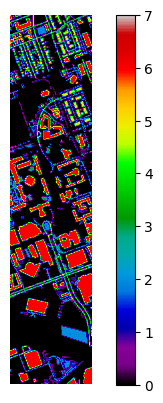

In [ ]:
plt.imshow(gt_3,cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')

(-0.5, 209.5, 953.5, -0.5)

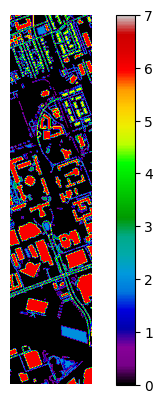

In [ ]:
plt.imshow(gt_2,cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')